## 不许复制

### Flag 1

什么，这题不是白给？直接用鼠标在菜单栏里点开开发者工具就能做出来。至于不让Ctrl+V，直接在开发者工具里删掉所有EventListener就好。


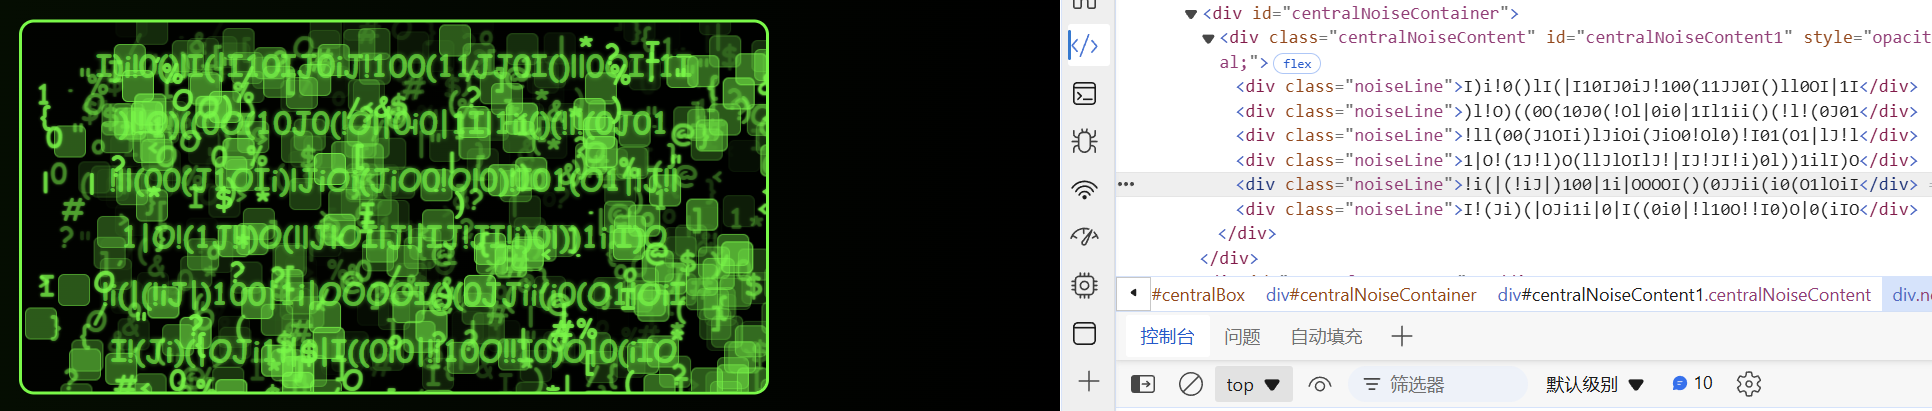

### Flag 2

阁下的定时检测Window Size确实厉害，但如果我派出Selenium，阁下又该如何应对？

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

In [2]:
chrome_options = Options()

# 启动 Chrome 浏览器
service = Service('./chromedriver.exe')  # 替换为 ChromeDriver 路径
driver = webdriver.Chrome(service=service, options=chrome_options)
driver.get("https://geekgame.pku.edu.cn/")

# 这里需要手动点开 Expert 页面，能自动但是我懒了

In [3]:
# Get all window handles
window_handles = driver.window_handles

# Switch to the new tab (the last one opened)
driver.switch_to.window(window_handles[-1])

html_body = driver.find_element(By.TAG_NAME, 'body').get_attribute('innerHTML')

print(html_body)  # Output the HTML body

html_body = driver.find_element(By.TAG_NAME, 'head').get_attribute('innerHTML')

print(html_body)  # Output the HTML body


    <div id="root" style="display: initial;"></div>

    <div id="inputContainer">
        <form action="?" method="post">
            <input type="text" id="noiseInput" name="response" placeholder="输入验证码" autocomplete="off" required="" pattern="[IJl\|1O0\(\)i!\s]+">
            <input type="hidden" name="ts" value="1729429168">
            <input type="hidden" name="certificate" value="5b942d241658d2f206c9b24875b6cc1e0f942d604b563ab1a2a8d9ebfb45f0b159da465a32be129bfbcec41c43c6c16095af5ab13c47c0f931150803ff7d9479">
            <button id="submitBtn" type="submit">提交</button>
        </form>
    </div>

    <script src="/static/js/page2.max.js"></script>



    <meta charset="UTF-8">
    <title>不许复制 · Expert 难度</title>
    <style>
        body, html {
            height: 100%;
            margin: 0;
            padding: 0;
            background: linear-gradient(270deg, #000000, #003300, #000000);
            background-size: 600% 600%;
            animation: gradientAnimation 15s ease

In [4]:
# 拿到整个渲染的DOM

rendered_dom = driver.execute_script("return document.documentElement.outerHTML")
print(rendered_dom)  # Output the rendered DOM

<html lang="zh-CN"><head>
    <meta charset="UTF-8">
    <title>不许复制 · Expert 难度</title>
    <style>
        body, html {
            height: 100%;
            margin: 0;
            padding: 0;
            background: linear-gradient(270deg, #000000, #003300, #000000);
            background-size: 600% 600%;
            animation: gradientAnimation 15s ease infinite;
            color: #0F0;
            font-family: "comic sans ms", sans-serif;
            overflow: hidden;
            position: relative;
        }

        @keyframes gradientAnimation {
            0% { background-position: 0% 50%; }
            50% { background-position: 100% 50%; }
            100% { background-position: 0% 50%; }
        }
        
        #inputContainer {
            position: absolute;
            bottom: 20px;
            left: 50%;
            transform: translateX(-50%);
            z-index: 6;
            display: flex;
            align-items: center;
        }
        #noiseInput {
      

诶不对啊，怎么在DOM里看不见呢？哦，原来是shadowDOM这位高手！我们遍历一下所有元素，看看shadowDOM挂在哪里：

In [5]:
elements = driver.find_elements(By.CSS_SELECTOR, "*")  # Get all elements
# print all elements
for element in elements:
    print(f"Tag: {element.tag_name}, InnerHTML: {element.get_attribute('innerHTML')}")
    # test if the element's shadow root is null
    shadow_root = driver.execute_script("return arguments[0].shadowRoot", element)

Tag: html, InnerHTML: <head>
    <meta charset="UTF-8">
    <title>不许复制 · Expert 难度</title>
    <style>
        body, html {
            height: 100%;
            margin: 0;
            padding: 0;
            background: linear-gradient(270deg, #000000, #003300, #000000);
            background-size: 600% 600%;
            animation: gradientAnimation 15s ease infinite;
            color: #0F0;
            font-family: "comic sans ms", sans-serif;
            overflow: hidden;
            position: relative;
        }

        @keyframes gradientAnimation {
            0% { background-position: 0% 50%; }
            50% { background-position: 100% 50%; }
            100% { background-position: 0% 50%; }
        }
        
        #inputContainer {
            position: absolute;
            bottom: 20px;
            left: 50%;
            transform: translateX(-50%);
            z-index: 6;
            display: flex;
            align-items: center;
        }
        #noiseInput {
   

诶不对啊，我怎么看不到shadowDOM里面的东西？让我看看[MDN](https://developer.mozilla.org/en-US/docs/Web/API/Web_components/Using_shadow_DOM)。哦，原来shadowDOM的mode是closed就没法通过JS访问了。那我们尝试让他在加载的时候变成open：

In [30]:
# select the last window
driver.switch_to.window(driver.window_handles[-1])
driver.execute_cdp_cmd('Page.addScriptToEvaluateOnNewDocument', {'source': """
Element.prototype._attachShadow = Element.prototype.attachShadow;
Element.prototype.attachShadow = function () {
    return this._attachShadow( { mode: "open" } );
};
"""})
driver.get("https://prob05.geekgame.pku.edu.cn/page2")
driver.execute_cdp_cmd('Page.addScriptToEvaluateOnNewDocument', {'source': """
Element.prototype._attachShadow = Element.prototype.attachShadow;
Element.prototype.attachShadow = function () {
    return this._attachShadow( { mode: "open" } );
};
"""})

{'identifier': '3'}

现在我们就能拿到ShadowDOM了：

In [31]:
elements = driver.find_elements(By.CSS_SELECTOR, "*")  # Get all elements
_shadow = None
# print all elements
for element in elements:
    print(f"Tag: {element.tag_name}, InnerHTML: {element.get_attribute('innerHTML')}")
    # test if the element's shadow root is null
    shadow_root = driver.execute_script("return arguments[0].shadowRoot", element)
    if shadow_root:
        print(f"Shadow root: Tag: {element.tag_name}")
        # print element attributes
        print(f"Attributes: {element.get_attribute('attributes')}")
        _shadow = shadow_root
        break

Tag: html, InnerHTML: <head>
    <meta charset="UTF-8">
    <title>不许复制 · Expert 难度</title>
    <style>
        body, html {
            height: 100%;
            margin: 0;
            padding: 0;
            background: linear-gradient(270deg, #000000, #003300, #000000);
            background-size: 600% 600%;
            animation: gradientAnimation 15s ease infinite;
            color: #0F0;
            font-family: "comic sans ms", sans-serif;
            overflow: hidden;
            position: relative;
        }

        @keyframes gradientAnimation {
            0% { background-position: 0% 50%; }
            50% { background-position: 100% 50%; }
            100% { background-position: 0% 50%; }
        }
        
        #inputContainer {
            position: absolute;
            bottom: 20px;
            left: 50%;
            transform: translateX(-50%);
            z-index: 6;
            display: flex;
            align-items: center;
        }
        #noiseInput {
   

In [32]:
# 删掉 floatingElementsContainer， 它创建了一堆东西

_floatingElementsContainer = _shadow.find_element(By.ID, 'floatingElementsContainer')
driver.execute_script("arguments[0].remove()", _floatingElementsContainer)

In [33]:
_ele = _shadow.find_element(By.CSS_SELECTOR, "*")  # Get all elements
# get outerHTML of _ele
print(_ele.get_attribute('outerHTML'))

<div id="centralBox">
        <div id="centralNoiseContainer">
            <div class="centralNoiseContent" id="centralNoiseContent1"><span class="chunk" id="chunk-he76ties" data-7g5cnnov="|JJii0l" data-7g9dhk4i="!I1!1JI" data-v9zy8zox="(|li)(0" data-rpsj1bd3="||i|" data-8sg59z1g="(Ii|" data-d3qitnlk=")i|0)(I" data-g8eeykx8="|0i10i(" data-3a5ltndo="|l!J||J">兄弟你好香</span><span class="chunk" id="chunk-zfa9iwv5" data-rrh2fbun="Oll|ll)" data-93hlnmaa="llO!(O0" data-fkqb5iyb="|l1I||I" data-wu89d3fo="(()0(0I" data-5zgnya0n="IIli" data-exjdhikg="OO|i|IO" data-o35fjipr="IliJ0ll" data-2ge2pb6d="O!1)">兄弟你好香</span><span class="chunk" id="chunk-4w40gcfi" data-g8lcqkhq="|11|" data-bvpqavak="IJ1Ol)!" data-8b5oll3m="III|(IO" data-15t79sok="0l0!l0O" data-xjljyd9n="|O||" data-qghzcuu4="!!1il|1" data-i81iehr4="iO|1)ll" data-wsy8jyt5="ii1|O1J">兄弟你好香</span><span class="chunk" id="chunk-x85rq6bc" data-ccck2p2d=")IJ|J)J" data-ogd72g5q="(0O11l)" data-79702stk="|i)l" data-0x53n3g5="0O(0OOl" data-9sjcbvtz="iJ!l

原来是先进的CSS防复制！这里的所有字符都写在CSS里。不急，让我们手动parse一下：

In [34]:
# find style element
_style = _ele.find_element(By.TAG_NAME, 'style')
_style.get_attribute('innerHTML')

'#chunk-b4bhg1xy::after{content:attr(data-etb6qq4k) attr(data-5l089wk0) attr(data-jso3vpzx) attr(data-rk7jtmee)}#chunk-kfa95btr::before{content:attr(data-en43cab2) attr(data-ctsd4v4p) attr(data-zq4s4xq9) attr(data-37bg3r0w)}#chunk-x85rq6bc::after{content:attr(data-ogd72g5q) attr(data-ccck2p2d) attr(data-0x53n3g5) attr(data-9sjcbvtz)}#chunk-pkg08rgn::after{content:attr(data-ku2h6xo3) attr(data-k953qo5f) attr(data-9qmbrgbn) attr(data-lvvoxfls)}#chunk-rvrsc3u7::after{content:attr(data-kqeark48) attr(data-ocnm0jdj) attr(data-ebheyvlh) attr(data-f7z6blup)}#chunk-8snmivez::before{content:attr(data-i45m60xn) attr(data-6sj5r0vp) attr(data-xaxis7ub) attr(data-gyaote80)}.chunk{font-size:0;color:transparent}#chunk-a2h7owml::after{content:attr(data-2xxm5ekr) attr(data-zgkyjg7s) attr(data-6ec5ug7f) attr(data-dv6azyo5)}#chunk-u5gzub0m::after{content:attr(data-0mupv5jk) attr(data-7fhsccsw) attr(data-kish158h) attr(data-cfrewj1o)}#chunk-chh0jsoz::after{content:attr(data-l1htlkfr) attr(data-1prlhjvv) a

In [35]:
# split by '#chunk-'
lines = _style.get_attribute('innerHTML').split('#chunk-')
lines

['',
 'b4bhg1xy::after{content:attr(data-etb6qq4k) attr(data-5l089wk0) attr(data-jso3vpzx) attr(data-rk7jtmee)}',
 'kfa95btr::before{content:attr(data-en43cab2) attr(data-ctsd4v4p) attr(data-zq4s4xq9) attr(data-37bg3r0w)}',
 'x85rq6bc::after{content:attr(data-ogd72g5q) attr(data-ccck2p2d) attr(data-0x53n3g5) attr(data-9sjcbvtz)}',
 'pkg08rgn::after{content:attr(data-ku2h6xo3) attr(data-k953qo5f) attr(data-9qmbrgbn) attr(data-lvvoxfls)}',
 'rvrsc3u7::after{content:attr(data-kqeark48) attr(data-ocnm0jdj) attr(data-ebheyvlh) attr(data-f7z6blup)}',
 '8snmivez::before{content:attr(data-i45m60xn) attr(data-6sj5r0vp) attr(data-xaxis7ub) attr(data-gyaote80)}.chunk{font-size:0;color:transparent}',
 'a2h7owml::after{content:attr(data-2xxm5ekr) attr(data-zgkyjg7s) attr(data-6ec5ug7f) attr(data-dv6azyo5)}',
 'u5gzub0m::after{content:attr(data-0mupv5jk) attr(data-7fhsccsw) attr(data-kish158h) attr(data-cfrewj1o)}',
 'chh0jsoz::after{content:attr(data-l1htlkfr) attr(data-1prlhjvv) attr(data-eazj61wu

In [36]:
import re

ATTR_REGEX = re.compile(r'attr(\([a-z0-9\-]+\))')

# get all matches
to_match = 'yyfp9h1d::after{content:attr(data-v7nuo5m9) attr(data-k84jsfme) attr(data-60k71pxt) attr(data-2r7gygdd)}'
matches = ATTR_REGEX.findall(to_match)
matches = [m.replace('(data-', '').replace(')', '') for m in matches]
matches

['v7nuo5m9', 'k84jsfme', '60k71pxt', '2r7gygdd']

In [37]:
chunk_data_blocks = {}

for l in lines:
    if not l.strip():
        continue
    # get chunk id
    chuk_id = l[:l.find('::')]
    chuk_data = chunk_data_blocks.get(chuk_id, [])
    print(chuk_id)
    _is_after = 'after' in l
    # get all matches
    to_match = l
    matches = ATTR_REGEX.findall(to_match)
    matches = [m.replace('(data-', '').replace(')', '') for m in matches]
    if _is_after:
        chuk_data.extend(matches)
    else:
        chuk_data = matches + chuk_data
    chunk_data_blocks[chuk_id] = chuk_data
    
for k, v in chunk_data_blocks.items():
    print(k, v)

b4bhg1xy
kfa95btr
x85rq6bc
pkg08rgn
rvrsc3u7
8snmivez
a2h7owml
u5gzub0m
chh0jsoz
5pc7w0y2
613t78aa
wvxe4cvj
rvrsc3u7
3jyn85v7
9v70ut6y
pkg08rgn
h7qygtdf
3xqvk47i
wl2yg6ma
b4bhg1xy
ms5oene7
nbhnz8s4
txqhvh2t
x2jidzpp
cwbjhb5b
5pc7w0y2
he76ties
f3qwp5ki
ow2hrpa0
613t78aa
u5gzub0m
he76ties
2myghk6n
rudjy74u
tgqro8xb
x85rq6bc
53lixsgu
rudjy74u
4w40gcfi
dcnns6ty
l2ka0s5s
zfa9iwv5
cwbjhb5b
idsxeqb9
chh0jsoz
xtanwxky
idsxeqb9
3jyn85v7
zfa9iwv5
x2jidzpp
wl2yg6ma
tgqro8xb
bhdrw4lq
xtanwxky
ms5oene7
gypoubjo
txqhvh2t
wvxe4cvj
2myghk6n
h7qygtdf
4w40gcfi
pmymm73a
nbhnz8s4
bhdrw4lq
5bss4wk5
5bss4wk5
yvkvrq8c
53lixsgu
dcnns6ty
f3qwp5ki
gypoubjo
9v70ut6y
kfa95btr
ow2hrpa0
l2ka0s5s
pmymm73a
a2h7owml
yvkvrq8c
8snmivez
3xqvk47i
b4bhg1xy ['g5vez6u7', 'n28a3e84', 'ib3khlpe', '0ly6ba21', 'etb6qq4k', '5l089wk0', 'jso3vpzx', 'rk7jtmee']
kfa95btr ['en43cab2', 'ctsd4v4p', 'zq4s4xq9', '37bg3r0w', '5z5ruvr0', 'aujsrlgy', 'yh2em7r7', 'mkms2fjn']
x85rq6bc ['nvvx5e1x', 'siu62j0j', 'k9o9kpjp', '79702stk', 'ogd72g5q'

In [38]:
# select all chunks
_chunks = _shadow.find_elements(By.CLASS_NAME, 'chunk')
_encoded = {}
_chuk_ids = []
# print all chunks
for chunk in _chunks:
    print(chunk.get_attribute('outerHTML'))
    # get id of chunk
    print(chunk.get_attribute('id'))
    _chuk_ids.append(chunk.get_attribute('id').replace('chunk-', ''))
    # get data* attributes (attributes that start with data)
    print(chunk.get_property('dataset'))
    # merge all data* attributes
    _encoded.update(chunk.get_property('dataset'))

<span class="chunk" id="chunk-he76ties" data-7g5cnnov="|JJii0l" data-7g9dhk4i="!I1!1JI" data-v9zy8zox="(|li)(0" data-rpsj1bd3="||i|" data-8sg59z1g="(Ii|" data-d3qitnlk=")i|0)(I" data-g8eeykx8="|0i10i(" data-3a5ltndo="|l!J||J">兄弟你好香</span>
chunk-he76ties
{'3a5ltndo': '|l!J||J', '7g5cnnov': '|JJii0l', '7g9dhk4i': '!I1!1JI', '8sg59z1g': '(Ii|', 'd3qitnlk': ')i|0)(I', 'g8eeykx8': '|0i10i(', 'rpsj1bd3': '||i|', 'v9zy8zox': '(|li)(0'}
<span class="chunk" id="chunk-zfa9iwv5" data-rrh2fbun="Oll|ll)" data-93hlnmaa="llO!(O0" data-fkqb5iyb="|l1I||I" data-wu89d3fo="(()0(0I" data-5zgnya0n="IIli" data-exjdhikg="OO|i|IO" data-o35fjipr="IliJ0ll" data-2ge2pb6d="O!1)">兄弟你好香</span>
chunk-zfa9iwv5
{'2ge2pb6d': 'O!1)', '5zgnya0n': 'IIli', '93hlnmaa': 'llO!(O0', 'exjdhikg': 'OO|i|IO', 'fkqb5iyb': '|l1I||I', 'o35fjipr': 'IliJ0ll', 'rrh2fbun': 'Oll|ll)', 'wu89d3fo': '(()0(0I'}
<span class="chunk" id="chunk-4w40gcfi" data-g8lcqkhq="|11|" data-bvpqavak="IJ1Ol)!" data-8b5oll3m="III|(IO" data-15t79sok="0l0!l0O" d

chunk-3jyn85v7
{'0bsg8m5e': '(iJ0', '1vwr25et': 'O(IJJ!I', '8llft2zh': 'JI(iJl0', 'j7fck5v0': 'IiJi1!!', 'w8t19c6u': 'IlIl', 'x0y45wb5': '!)!0!!1', 'x8ks503c': ')liI0OJ', 'xh4qtfy2': 'OOO!|IJ'}
<span class="chunk" id="chunk-chh0jsoz" data-s21dol4s="Ili0!1J" data-wpri9jbs="l)|i0Ii" data-lvu9rdda="I|!0" data-p163l5on="JIi|))(" data-l1htlkfr="ilJ|i10" data-1prlhjvv="(iJ(J01" data-t0fz0v75="|!iI" data-eazj61wu="(l0!)Ol">兄弟你好香</span>
chunk-chh0jsoz
{'1prlhjvv': '(iJ(J01', 'eazj61wu': '(l0!)Ol', 'l1htlkfr': 'ilJ|i10', 'lvu9rdda': 'I|!0', 'p163l5on': 'JIi|))(', 's21dol4s': 'Ili0!1J', 't0fz0v75': '|!iI', 'wpri9jbs': 'l)|i0Ii'}
<span class="chunk" id="chunk-rudjy74u" data-2s8f8zml="O)||liJ" data-z0hh7k67="(OI((0!" data-jr8arjum="l|111I0" data-edflecc5="IlO|" data-ukh2m1pa="I0)(IJl" data-q7oahfny="|liJ|J!" data-no424odl="Jl0J!Ji" data-9ee5tmuq="Ii0)">兄弟你好香</span>
chunk-rudjy74u
{'2s8f8zml': 'O)||liJ', '9ee5tmuq': 'Ii0)', 'edflecc5': 'IlO|', 'jr8arjum': 'l|111I0', 'no424odl': 'Jl0J!Ji', 'q7oahfny

现在我们拿到了每个Span里的明文，调整一下顺序，就可以拿到flag了。

In [39]:
_encoded

{'3a5ltndo': '|l!J||J',
 '7g5cnnov': '|JJii0l',
 '7g9dhk4i': '!I1!1JI',
 '8sg59z1g': '(Ii|',
 'd3qitnlk': ')i|0)(I',
 'g8eeykx8': '|0i10i(',
 'rpsj1bd3': '||i|',
 'v9zy8zox': '(|li)(0',
 '2ge2pb6d': 'O!1)',
 '5zgnya0n': 'IIli',
 '93hlnmaa': 'llO!(O0',
 'exjdhikg': 'OO|i|IO',
 'fkqb5iyb': '|l1I||I',
 'o35fjipr': 'IliJ0ll',
 'rrh2fbun': 'Oll|ll)',
 'wu89d3fo': '(()0(0I',
 '15t79sok': '0l0!l0O',
 '8b5oll3m': 'III|(IO',
 'bvpqavak': 'IJ1Ol)!',
 'g8lcqkhq': '|11|',
 'i81iehr4': 'iO|1)ll',
 'qghzcuu4': '!!1il|1',
 'wsy8jyt5': 'ii1|O1J',
 'xjljyd9n': '|O||',
 '0x53n3g5': '0O(0OOl',
 '79702stk': '|i)l',
 '9sjcbvtz': 'iJ!l',
 'ccck2p2d': ')IJ|J)J',
 'k9o9kpjp': '!OlO1!|',
 'nvvx5e1x': 'iO|(J11',
 'ogd72g5q': '(0O11l)',
 'siu62j0j': '1iJ!)Ji',
 '13c6c1mt': '|(1!1l)',
 '16pm3rf0': '|1(I!!|',
 'hso2t0uv': ')Ii|0)J',
 'li3ewhgu': 'lJ|(i(i',
 'nqwobiti': 'l0!0!0l',
 'ppm915or': '()|!',
 'srlaaa9v': '|iIO',
 'syphnj0f': ')JJ(J|!',
 '9qmbrgbn': 'i!(!liJ',
 'ae2y75ji': '|11JiiO',
 'k953qo5f': 'lJi(1Ii'

In [40]:
res = ''

for chuk in _chuk_ids:
    print(''.join(_encoded[m] for m in chunk_data_blocks[chuk]))
    res += ''.join(_encoded[m] for m in chunk_data_blocks[chuk])

!I1!1JI|JJii0l)i|0)(I||i||l!J||J|0i10i((|li)(0(Ii|
OO|i|IOOll|ll)IliJ0llO!1)(()0(0I|l1I||IllO!(O0IIli
IJ1Ol)!ii1|O1JiO|1)ll|11|!!1il|10l0!l0OIII|(IO|O||
iO|(J111iJ!)Ji!OlO1!||i)l(0O11l))IJ|J)J0O(0OOliJ!l
)Ii|0)J|1(I!!|lJ|(i(i()|!|(1!1l))JJ(J|!l0!0!0l|iIO
|11JiiO11l)!i0JJ01)lI01J|JiJl1()lJi(1Iii!(!liJiI01
0l|!(OJlO)Ji(ii|i1(!00)100J)01)J(iO)!))1(0II01|J1O
1IJ1li|IlIIOi1i|J10)iJO|Ji0!OiOJIJO))(01OI(Oii|OOi
)liI0OJO(IJJ!IIiJi1!!IlIlJI(iJl0OOO!|IJ!)!0!!1(iJ0
Ili0!1Jl)|i0IiJIi|))(I|!0ilJ|i10(iJ(J01(l0!)Ol|!iI
(OI((0!l|111I0Jl0J!JiIlO|I0)(IJlO)||liJ|liJ|J!Ii0)
|OO0J|1(()((l!JO|I!IiO0)IJ(Oli|ii!lJ(!(O1iJ(J!OJ!I
ll!lO1J1()OJ1(!)(1)ll00!(I|IO!((ili!l)i)OOI|1(l0I0
!IJ)|li1|IJl(i)IIiO(|lJ|)J)(|)i!01|O1)0Ol0O1O|1JI|
1ll|lOOO0iI1)00(1I)i)Oi!))|!)JO!(li!IiiiiJ0OilIl()
I!!!01l01J|1!1)11JlO0OI1!Jl(J)l(l|I|1IlJ!1|(l(0)0(
l(I|llOl!|IIl(0iJ(Ji)l|0O0I(!!)|!I)(J|!0O(1|J0|(Oi
lI000|1l|)!l!I!!l|OlIIli|JOOI(l)Ol0||l!JJ1)|0!|!!i
)IJOO1|1!((lJlO)J1IOJ|!)01!OlJ!|O1(OJJJJ|)))|i10(1
OJO!|)OO)i|(00)I|(Oi1Ji!J!l)00O

什么，还是不让复制？还是Selenium启动：

In [41]:
# find the input id="noiseInput
input_ele = driver.find_element(By.ID, 'noiseInput')
# input the result
input_ele.send_keys(res)

In [42]:
# find submitBtn and click
submit_btn = driver.find_element(By.ID, 'submitBtn')
submit_btn.click()

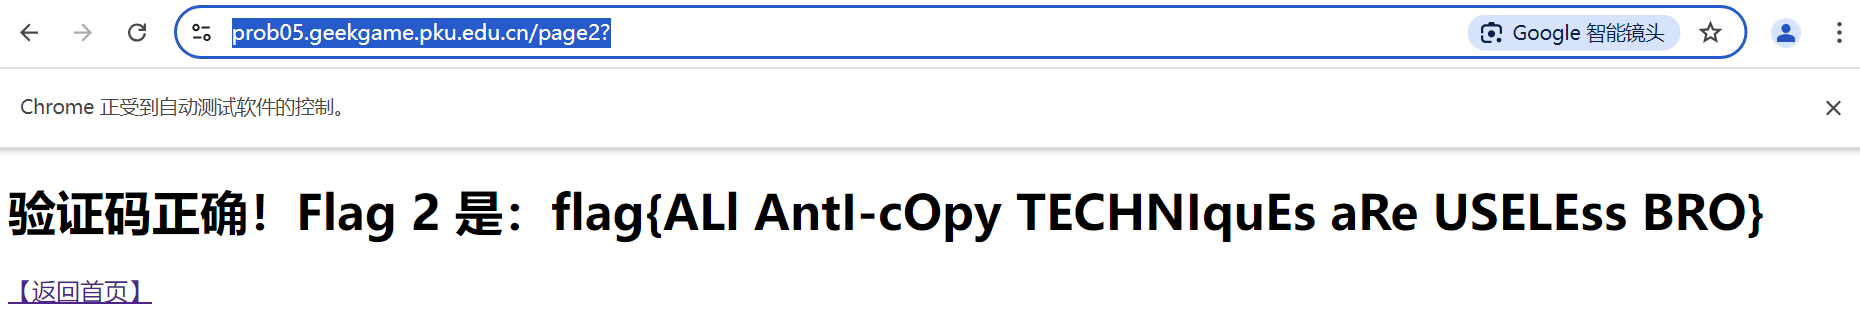